(modis_level1b)=
# Reading modis level1b data

## Background

https://mcst.gsfc.nasa.gov/l1b/software-system-overview

https://modis.gsfc.nasa.gov/about/specifications.php

https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/intro-to-hdf4/

modis swath:  https://svs.gsfc.nasa.gov/3348

In [1]:
import pprint
from pathlib import Path

import a301_lib
import numpy as np
from matplotlib import pyplot as plt
from pyhdf.SD import SD
from pyhdf.SD import SDC

******************************
context imported. Front of path:
/home/phil/work



## get all files from the data_dir that end in hdf

the `PosixPath` object is the way that python is able to treat all folder paths the same, whether they look like `C:\Users\phil` or `/Users/home/phil`

There is only 1 hdf file in `sat_data`, so the cell below returns a list of length 1

In [2]:
print(a301_lib.sat_data)

/home/phil/work/sat_data


In [3]:
hdf4_dir = a301_lib.sat_data / 'hdf4_files'
all_files = list(hdf4_dir.glob("*MYD02*2105*hdf"))
print(all_files)

[PosixPath('/home/phil/work/sat_data/hdf4_files/MYD021KM.A2013222.2105.061.2018047235850.hdf')]


Now read that file (converting PosixPath into a string since the pyhdf library is
expecting a string).  Use the `.info` method to get the number of datasets and attributes

In [4]:
file_name = str(all_files[0])
print(f"reading {file_name}")
the_file = SD(file_name, SDC.READ)
stars = "*" * 50
print(
    (
        f"\n{stars}\n"
        f"number of datasets, number of attributes\n"
        f"={the_file.info()}\n"
        f"{stars}\n"
        f"\nHere is the help file for the info funtion:\n"
    )
)
#help(SD.info)

reading /home/phil/work/sat_data/hdf4_files/MYD021KM.A2013222.2105.061.2018047235850.hdf



**************************************************
number of datasets, number of attributes
=(31, 58)
**************************************************

Here is the help file for the info funtion:



## Find the dataset and print their indices

We know we've got 31 datasets in the file -- what are their names?

In [5]:
datasets_dict = the_file.datasets()

for idx, sds in enumerate(datasets_dict.keys()):
    print(idx, sds)

#breakpoint()

0 Latitude
1 Longitude
2 EV_1KM_RefSB
3 EV_1KM_RefSB_Uncert_Indexes
4 EV_1KM_Emissive
5 EV_1KM_Emissive_Uncert_Indexes
6 EV_250_Aggr1km_RefSB
7 EV_250_Aggr1km_RefSB_Uncert_Indexes
8 EV_250_Aggr1km_RefSB_Samples_Used
9 EV_500_Aggr1km_RefSB
10 EV_500_Aggr1km_RefSB_Uncert_Indexes
11 EV_500_Aggr1km_RefSB_Samples_Used
12 Height
13 SensorZenith
14 SensorAzimuth
15 Range
16 SolarZenith
17 SolarAzimuth
18 gflags
19 EV_Band26
20 EV_Band26_Uncert_Indexes
21 Band_250M
22 Band_500M
23 Band_1KM_RefSB
24 Band_1KM_Emissive
25 Noise in Thermal Detectors
26 Change in relative responses of thermal detectors
27 DC Restore Change for Thermal Bands
28 DC Restore Change for Reflective 250m Bands
29 DC Restore Change for Reflective 500m Bands
30 DC Restore Change for Reflective 1km Bands


 ## open one of the datasets (number 4, EV_1KM_Emissive) and get its shape and data type
 
 The "Earth View Emissive" dataset contains all the longwave channels, and all the 2030 rows and 1354 columns for each
 pixel in each channel

In [6]:
longwave_data = the_file.select("EV_1KM_Emissive")  # select sds
print(longwave_data.info())

('EV_1KM_Emissive', 3, [16, 2040, 1354], 23, 8)


## Get the first row of the first channel and find its numpy dtype

uint16 is "unsigned 16 bit integer", which is how the modis raw counts are stored.  By using
2 8-bit words (2 bytes) for each measurement they can represent (2**16)-1 = 65535 radiance values.  This means, however that every measurement has to be converted from uin16 to float32 before it
can be used

In [7]:
data_row = longwave_data[0, 0, :]  # get sds data
print(data_row.shape, data_row.dtype)

(1354,) uint16


## get all the rows and columns for the first channel

In [8]:
longwave_data[0, :, :]

array([[4799, 4471, 5255, ..., 7359, 7389, 7562],
       [5119, 4523, 5478, ..., 7736, 7781, 7811],
       [5152, 4442, 5809, ..., 7831, 7629, 7674],
       ...,
       [7965, 8175, 8227, ..., 7914, 7413, 7600],
       [7943, 7801, 7831, ..., 7539, 7404, 7223],
       [7926, 7955, 7799, ..., 7209, 7344, 6985]], dtype=uint16)

## Find the attributes for EV_1KM_Emissive

In order to make the conversion from int to float, we need to
multiply by a scale factor and subtract an offset.  These are
stored as attributes in the hdf file, and they are different
for each of the 16 channels.  Use `pprint` to pretty-print the big
dictionary.

In [9]:
pprint.pprint(longwave_data.attributes())

{'_FillValue': 65535,
 'band_names': '20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36',
 'long_name': 'Earth View 1KM Emissive Bands Scaled Integers',
 'radiance_offsets': [2467.264404296875,
                      2480.6005859375,
                      2478.176513671875,
                      2402.468505859375,
                      1077.44482421875,
                      1560.3333740234375,
                      2724.21826171875,
                      2317.48828125,
                      2610.015380859375,
                      1560.333251953125,
                      2035.9332275390625,
                      2119.08447265625,
                      2500.599365234375,
                      2499.093505859375,
                      2500.5205078125,
                      2495.89111328125],
 'radiance_scales': [6.9307534431573e-05,
                     0.00346690253354609,
                     7.626575097674504e-05,
                     8.990753121906891e-05,
                     3.1556141

## Print the first 1000 characters of the Metadata.0 string

Date, orbit number, etc. are stored in a long string attribute called 'StructMetadata.0'.
The \t character is a tab stop so the file is easier to read with an editor.

In [10]:
pprint.pprint(the_file.attributes()["StructMetadata.0"][:1000])

('GROUP=SwathStructure\n'
 '\tGROUP=SWATH_1\n'
 '\t\tSwathName="MODIS_SWATH_Type_L1B"\n'
 '\t\tGROUP=Dimension\n'
 '\t\t\tOBJECT=Dimension_1\n'
 '\t\t\t\tDimensionName="Band_250M"\n'
 '\t\t\t\tSize=2\n'
 '\t\t\tEND_OBJECT=Dimension_1\n'
 '\t\t\tOBJECT=Dimension_2\n'
 '\t\t\t\tDimensionName="Band_500M"\n'
 '\t\t\t\tSize=5\n'
 '\t\t\tEND_OBJECT=Dimension_2\n'
 '\t\t\tOBJECT=Dimension_3\n'
 '\t\t\t\tDimensionName="Band_1KM_RefSB"\n'
 '\t\t\t\tSize=15\n'
 '\t\t\tEND_OBJECT=Dimension_3\n'
 '\t\t\tOBJECT=Dimension_4\n'
 '\t\t\t\tDimensionName="Band_1KM_Emissive"\n'
 '\t\t\t\tSize=16\n'
 '\t\t\tEND_OBJECT=Dimension_4\n'
 '\t\t\tOBJECT=Dimension_5\n'
 '\t\t\t\tDimensionName="10*nscans"\n'
 '\t\t\t\tSize=2040\n'
 '\t\t\tEND_OBJECT=Dimension_5\n'
 '\t\t\tOBJECT=Dimension_6\n'
 '\t\t\t\tDimensionName="Max_EV_frames"\n'
 '\t\t\t\tSize=1354\n'
 '\t\t\tEND_OBJECT=Dimension_6\n'
 '\t\t\tOBJECT=Dimension_7\n'
 '\t\t\t\tDimensionName="2*nscans"\n'
 '\t\t\t\tSize=408\n'
 '\t\t\tEND_OBJECT=Dimension_7\n'

## Now plot the data using imshow

Start over again and make a plot.  We need to be
able to identify particular bands  -- the channel numbers
are stored in the "Band_1KM_Emissive" dataset

In [11]:
longwave_bands = the_file.select("Band_1KM_Emissive")

In [12]:
longwave_bands.info()

('Band_1KM_Emissive', 1, 16, 5, 1)

In [13]:
band_nums = longwave_bands.get()
print(f"here are the modis channels in the emissive dataset \n{band_nums}")

here are the modis channels in the emissive dataset 
[20. 21. 22. 23. 24. 25. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.]


Note that only channels 20 to 36 are in the Emissive dataset (see [the Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php))

Note that only channels 20 to 36 are in the Emissive dataset (see [the Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php))

## find the index for channel 30

Count the items in the vector above and convince yourself that channel 30 is index 9, starting from 0

But there's a better way: use numpy.searchsorted to find the index with the closest value
to 30:

We also need to turn that index (type int64) into a plain python int so it can be used to specify the channel

In [14]:
ch30_index = np.searchsorted(band_nums, 30.0)
print(f"make sure our index datatime in int64: {ch30_index.dtype}")
ch30_index = int(ch30_index)
print(f"channel 30 is located at index {ch30_index}")


# ## Read channel 30 at index 9 into a numpy array of type uint16

make sure our index datatime in int64: int64
channel 30 is located at index 9


## Now get the data for channel 30

In [15]:
ch30_data = longwave_data[ch30_index, :, :]
print(ch30_data.shape)
print(ch30_data.dtype)
#breakpoint()

(2040, 1354)
uint16


Plot the channel 30 image

Use [imshow with a colorbar](https://matplotlib.org/gallery/color/colorbar_basics.html#sphx-glr-gallery-color-colorbar-basics-py)

(2040, 1354)


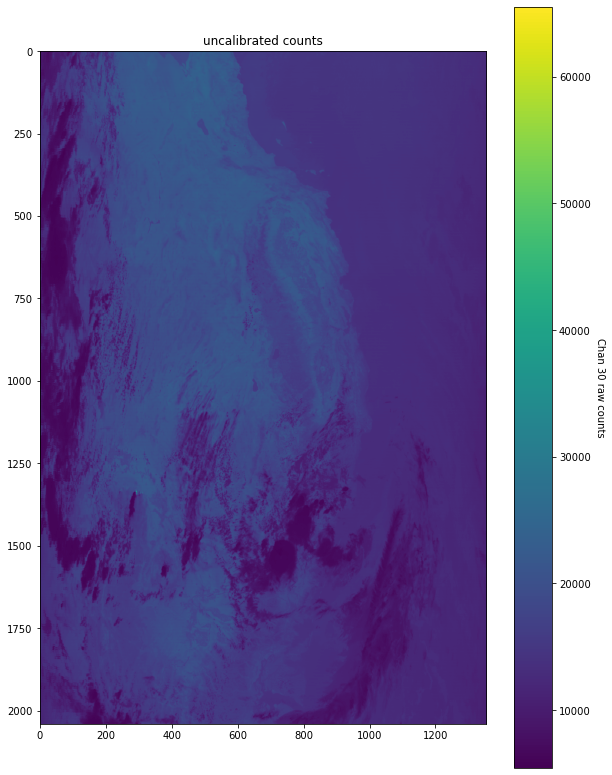

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
CS = ax.imshow(ch30_data)
cax = fig.colorbar(CS)
ax.set_title("uncalibrated counts")
#
# add a label to the colorbar and flip it around 270 degrees
# (just my personal preference for labels)
#
out = cax.ax.set_ylabel("Chan 30 raw counts")
out.set_verticalalignment("bottom")
out.set_rotation(270)
print(ch30_data.shape)

## Now convert the raw counts to radiances

We need to find the right scale and offset for channel 30

To turn the raw counts into pixel radiances, you need to apply equation 5.8 on p. 36 of the
[modis users guide](https://www.dropbox.com/s/ckd3dv4n7nxc9p0/modis_users_guide.pdf?dl=0):

$Radiances = (RawData - offset) \times scale$

We have just read the RawData,  the offset and the scale are stored in two vectors that are attributes of the Emissive dataset.  We'll make a version of the figure above, but plot Channel 30 radiance (in W/m^2/micron/sr), rather than raw counts.

In [17]:
scales = longwave_data.attributes()["radiance_scales"]
offsets = longwave_data.attributes()["radiance_offsets"]
ch30_scale = scales[ch30_index]
ch30_offset = offsets[ch30_index]
print(f"scale: {ch30_scale}, offset: {ch30_offset}")

scale: 0.0004063234373461455, offset: 1560.333251953125


In [18]:
ch30_calibrated = (ch30_data - ch30_offset) * ch30_scale

## Plot the Channel 30 radiances

Do these look right?  How would you tell?

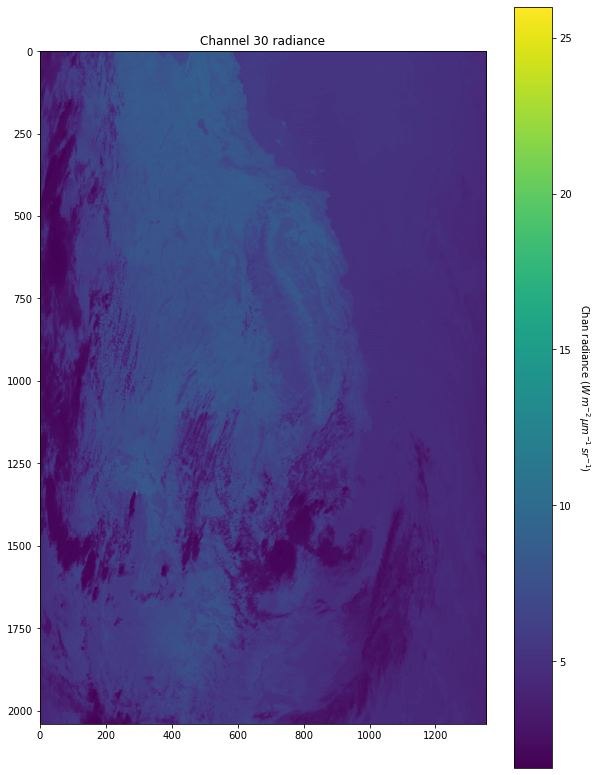

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
CS = ax.imshow(ch30_calibrated)
cax = fig.colorbar(CS)
ax.set_title("Channel 30 radiance")
#
# add a label to the colorbar and flip it around 270 degrees
#
out = cax.ax.set_ylabel("Chan radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1})$")
out.set_verticalalignment("bottom")
out.set_rotation(270)
ch30_calibrated.shape
#
# close the file
#
the_file.end()

## Write the radiances out for safekeeping

Follow the example here: https://hdfeos.org/software/pyhdf.php

In [20]:
# Create an HDF file
outname = "ch30_out.hdf"
sd = SD(outname, SDC.CREATE | SDC.WRITE | SDC.TRUNC)

# Create a dataset
sds = sd.create("ch30", SDC.FLOAT64, ch30_calibrated.shape)

# Fill the dataset with a fill value
sds.setfillvalue(0)

# Set dimension names
dim1 = sds.dim(0)
dim1.setname("row")
dim2 = sds.dim(1)
dim2.setname("col")

# Assign an attribute to the dataset
sds.units = "W/m^2/micron/sr"

# Write data
sds[:, :] = ch30_calibrated

# Close the dataset
sds.endaccess()

# Flush and close the HDF file
sd.end()

Did this work?  See if the file exists:

In [21]:
hdf_files = list(Path().glob("*hdf"))
print(hdf_files)

[PosixPath('ch30_out.hdf')]


## move all of this into a function

reading /home/phil/work/sat_data/hdf4_files/MYD021KM.A2013222.2105.061.2018047235850.hdf
9


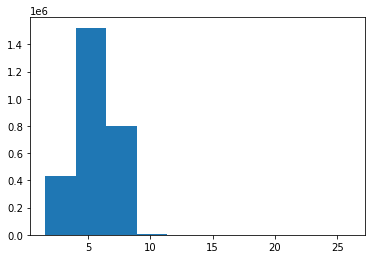

In [22]:
file_name = str(all_files[0])
print(f"reading {file_name}")
the_file = SD(file_name, SDC.READ)
the_band=30

def readband(the_file,the_band):
    """
    read and calibrate a MODIS band from an open hdf4 SD dataset
    
    Parameters
    ----------
    
       the_file:pyhdf.SD object
           the dataset open for reading
       the_band: int
           band number for MODIS (1-36)
           
    Returns
    -------
       the_chan_calibrated: ndarray
           the pixel radiances in W/m^2/sr/micron
    """
    longwave_data = the_file.select("EV_1KM_Emissive")  # select sds
    longwave_bands = the_file.select("Band_1KM_Emissive")
    band_nums = longwave_bands.get()
    thechan_index = int(np.searchsorted(band_nums, the_band))
    print(thechan_index)
    thechan_data = longwave_data[thechan_index, :, :]
    scales = longwave_data.attributes()["radiance_scales"]
    offsets = longwave_data.attributes()["radiance_offsets"]
    thechan_scale = scales[thechan_index]
    thechan_offset = offsets[thechan_index]
    thechan_calibrated = (thechan_data - thechan_offset) * thechan_scale
    return thechan_calibrated

ch_radiance = readband(the_file,the_band)
the_file.end()
from matplotlib import pyplot as plt
plt.hist(ch_radiance.flat)
plt.show()